In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from gymnasium import spaces


## Funcioens

In [21]:
class VacuumGridEnv:
    """
    Entorno de robot aspiradora configurable en tamaño y resbalamiento.
    - grid: lista de listas de caracteres, ej: [['S','H'],['F','G']]
    - slippery_chars: caracter que indica suelo resbaloso, ej: {'H'}
    """
    def __init__(self, grid, slippery_chars={'H', 'F'}):
        self.grid = grid
        self.n_rows = len(grid)
        self.n_cols = len(grid[0])
        self.nS = self.n_rows * self.n_cols
        self.nA = 4
        self.state = 0
        self.visited = [False] * self.nS
        # Acciones: Izq, Abajo, Der, Arriba
        self.movs = [(-1, 0), (0, 1), (1, 0), (0, -1)]
        # Mapeo de estados a coordenadas y viceversa
        self.coord = {}
        self.coord_inv = {}
        idx = 0
        for y in range(self.n_rows):
            for x in range(self.n_cols):
                self.coord[idx] = (x, y)
                self.coord_inv[(x, y)] = idx
                idx += 1
        # Estados resbalosos según los caracteres
        self.slippery_states = set()
        for s in range(self.nS):
            x, y = self.coord[s]
            if grid[y][x] in slippery_chars:
                self.slippery_states.add(s)

        self.observation_space = type('', (), {})()
        self.observation_space.n = self.nS
        self.action_space = type('', (), {})()
        self.action_space.n = self.nA

        self.P = self._build_P()
        self.unwrapped = self

    def _build_P(self):
        P = {s: {a: [] for a in range(self.nA)} for s in range(self.nS)}
        for s in range(self.nS):
            for a in range(self.nA):
                x, y = self.coord[s]
                dx, dy = self.movs[a]
                nx, ny = x + dx, y + dy
                # Si se sale, se queda en el mismo estado
                if 0 <= nx < self.n_cols and 0 <= ny < self.n_rows:
                    next_s = self.coord_inv[(nx, ny)]
                    is_goal = self.grid[ny][nx] == 'G'
                else:
                    next_s = s
                    is_goal = False
                reward = 10 if is_goal else -1
                done = is_goal
                if s in self.slippery_states:
                    # 80% avanza, 20% se queda
                    P[s][a].append((0.8, next_s, reward, done))
                    P[s][a].append((0.2, s, -1, done))
                else:
                    P[s][a].append((1.0, next_s, reward, done))
        return P

    def reset(self):
        self.state = 0
        self.visited = [False] * self.nS
        return self.state

    def step(self, action):
        transitions = self.P[self.state][action]
        probs = [t[0] for t in transitions]
        idx = np.random.choice(len(transitions), p=probs)
        prob, next_state, reward, done = transitions[idx]
        x, y = self.coord[next_state]
        if self.grid[y][x] == 'G' and not self.visited[next_state]:
            done = True
            reward = 10
            self.visited[next_state] = True
        else:
            done = (self.grid[y][x] == 'G')
            reward = -1
        self.state = next_state
        return self.state, reward, done, False, {}


In [22]:
def policy_evaluation(env, policy_vec, val_fun_vec, conv_tolerance, discount=0.9):
    """Evaluación de la política"""
    while True:
        delta = 0
        for state in env.unwrapped.P:
            prev_val = val_fun_vec[state]
            expected_return = sum([prob*(reward + discount*val_fun_vec[next_state]) 
                                      for prob,next_state,reward,is_terminal_state 
                                      in env.unwrapped.P[state][policy_vec[state]]])
            val_fun_vec[state] = expected_return
            delta = np.max([delta, np.abs(prev_val - val_fun_vec[state])])

        if(delta < conv_tolerance):
            return policy_vec, val_fun_vec


In [23]:
def policy_improvement(env,policy_vec, val_fun_vec, policy_stable_vec, discount=0.9):
    """Mejoramiento de la política"""
    for state in env.unwrapped.P:
        old_action = policy_vec[state]
        action_values = np.zeros(env.action_space.n)
        for action_p in env.unwrapped.P[state]:
            action_values[action_p] = sum([prob*(reward + discount*val_fun_vec[next_state]) 
                                           for prob, next_state, reward, is_terminal_state 
                                           in env.unwrapped.P[state][action_p]])
        policy_vec[state] = np.argmax(action_values)
        if old_action == policy_vec[state]:
            policy_stable_vec[state] = True
    return policy_vec, policy_stable_vec

In [24]:
def policy_iteration(env, discount = 0.9, conv_tolerance=1e-4, max_iterations=100):
    """Algoritmo de iteración de política"""
    policy_stable_vec = np.zeros(env.observation_space.n, dtype=bool)
    val_fun_vec = np.zeros(env.observation_space.n)
    policy_vec = np.random.randint(0, env.action_space.n, size=env.observation_space.n, dtype=int)
    for _ in range(max_iterations):
        policy_vec, val_fun_vec = policy_evaluation(env, policy_vec, val_fun_vec, 
                                                                       conv_tolerance, discount=discount)
        policy_vec, policy_stable_vec = policy_improvement(env,policy_vec, val_fun_vec, policy_stable_vec, 
                                                           discount=discount)
        
        if np.all(policy_stable_vec == True):
            return policy_vec, val_fun_vec

In [25]:
def values_print(valueFunction,reshapeDim=None):
    reshapeDim = int(np.sqrt(len(valueFunction)))
    ax = sns.heatmap(valueFunction.reshape(reshapeDim,reshapeDim),annot=True, square=True,cbar=False, 
                     cmap='Blues',xticklabels=False, yticklabels=False)
    plt.title('Función de valor por cada estado')
    plt.show()

def actions_print(policy_vec=None):
    action_names = {0: 'Izquierda', 1: 'Abajo', 2: 'Derecha', 3: 'Arriba'}
    reshapeDim = int(np.sqrt(len(policy_vec)))
    ax = sns.heatmap(policy_vec.reshape(reshapeDim,reshapeDim),annot=np.array([action_names[a] for a in policy_vec]).reshape(reshapeDim,reshapeDim), 
                     fmt='',cbar=False, cmap='Oranges',xticklabels=False, yticklabels=False)
    plt.title('Política en cada estado')
    plt.show()


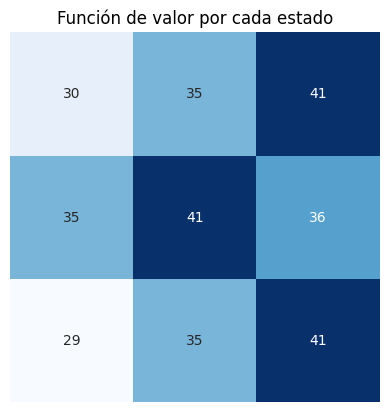

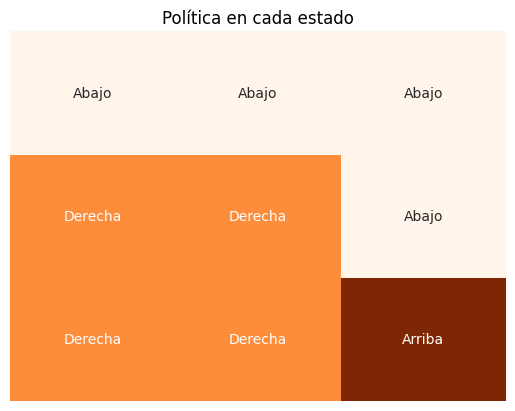

In [26]:
grid = [['S','F','F'],['F','F','G'],['F','F','F']]
env = VacuumGridEnv(grid, slippery_chars={'F'})
#env = VacuumGridEnv(grid, slippery_chars=set())
action_names = {0: 'Izquierda', 1: 'Abajo', 2: 'Derecha', 3: 'Arriba'}
policy_vec, val_fun_vec = policy_iteration(env, discount=0.9)

values_print(val_fun_vec)
actions_print(policy_vec)


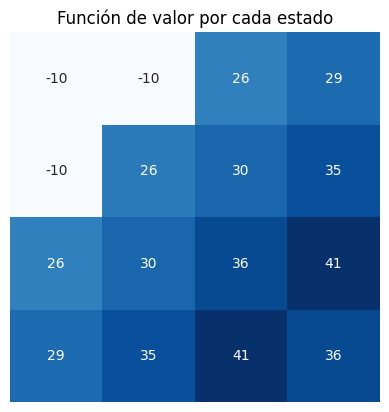

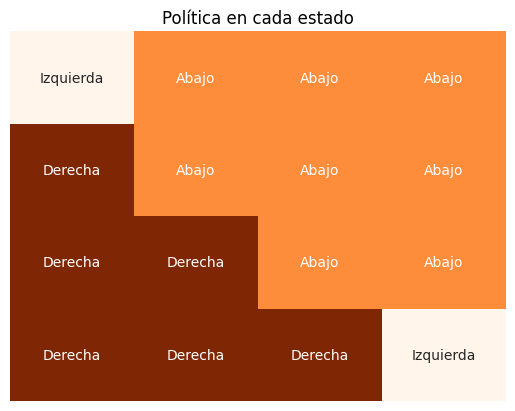

In [27]:
#env = VacuumGridEnv(grid, slippery_chars=set())
env = VacuumGridEnv(grid=["SFFF", "FHFF", "FFHF", "FFFG"], slippery_chars={'F'})
action_names = {0: 'Izquierda', 1: 'Abajo', 2: 'Derecha', 3: 'Arriba'}
policy_vec, val_fun_vec = policy_iteration(env, discount=0.9)

values_print(val_fun_vec)
actions_print(policy_vec)


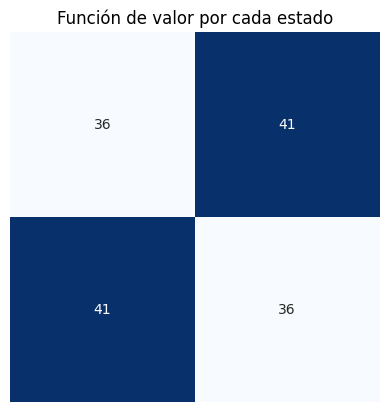

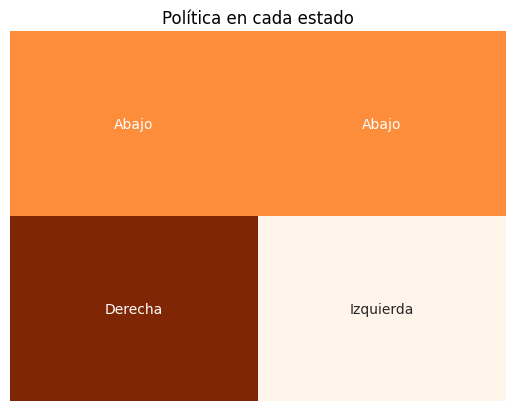

In [28]:
#env = VacuumGridEnv(grid, slippery_chars=set())
env = VacuumGridEnv(grid=["SF", "FG"], slippery_chars={'F'})
action_names = {0: 'Izquierda', 1: 'Abajo', 2: 'Derecha', 3: 'Arriba'}
policy_vec, val_fun_vec = policy_iteration(env, discount=0.9)

values_print(val_fun_vec)
actions_print(policy_vec)

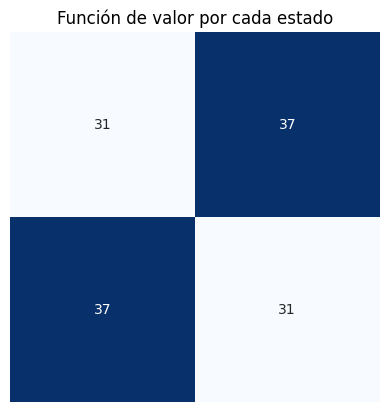

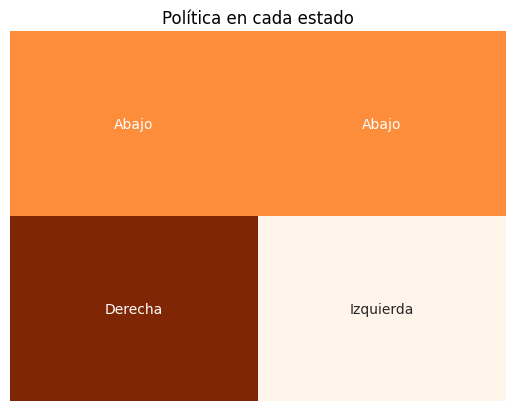

In [29]:
#env = VacuumGridEnv(grid, slippery_chars=set())
env = VacuumGridEnv(grid=["SF", "FG"], slippery_chars={"S","F", "G"})
action_names = {0: 'Izquierda', 1: 'Abajo', 2: 'Derecha', 3: 'Arriba'}
policy_vec, val_fun_vec = policy_iteration(env, discount=0.9)

values_print(val_fun_vec)
actions_print(policy_vec)

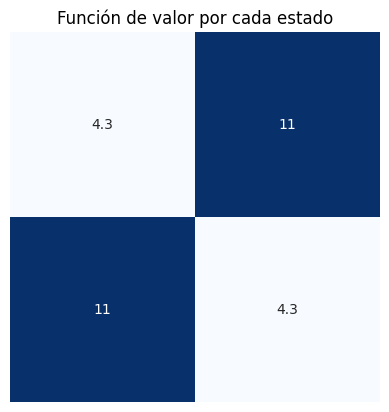

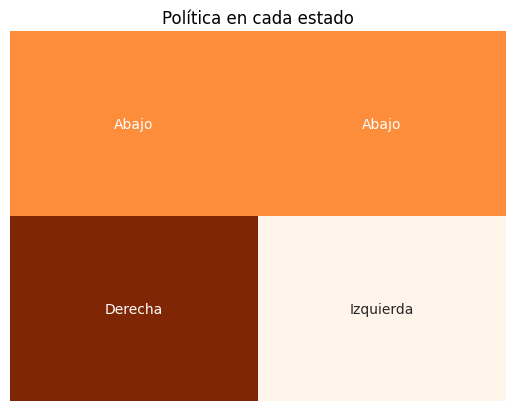

In [30]:
#env = VacuumGridEnv(grid, slippery_chars=set())
env = VacuumGridEnv(grid=["SF", "FG"], slippery_chars={'F'})
action_names = {0: 'Izquierda', 1: 'Abajo', 2: 'Derecha', 3: 'Arriba'}
policy_vec, val_fun_vec = policy_iteration(env, discount=0.5)

values_print(val_fun_vec)
actions_print(policy_vec)

## implementacion heredando

In [31]:
## Implementación alternativa sin heredar de gym.Env, para compatibilidad con el código de policy iteration
class VacuumGridEnv(gym.Env):
    """
    Entorno de robot aspiradora en una casa 2x2 con resbalamiento.
    Estados: 0=A, 1=B, 2=C, 3=D (base de recarga)
    Acciones: 0=Izquierda, 1=Abajo, 2=Derecha, 3=Arriba
    """
    metadata = {"render_modes": ["human", "ansi"]}

    def __init__(self):
        super().__init__()
        self.nS = 4  # número de estados
        self.nA = 4  # número de acciones
        self.observation_space = spaces.Discrete(self.nS)
        self.action_space = spaces.Discrete(self.nA)
        self.state = 0
        self.visited = [False] * self.nS  # Para saber si ya llegó a D

        # Mapeo de acciones: Izq, Abajo, Der, Arriba
        self.movs = [(-1, 0), (0, 1), (1, 0), (0, -1)]
        # Mapeo de estados a coordenadas
        self.coord = {0: (0, 0), 1: (1, 0), 2: (0, 1), 3: (1, 1)}
        self.coord_inv = {v: k for k, v in self.coord.items()}

        # Tabla de transición P
        self.P = self._build_P()

    def _build_P(self):
        P = {s: {a: [] for a in range(self.nA)} for s in range(self.nS)}
        for s in range(self.nS):
            for a in range(self.nA):
                x, y = self.coord[s]
                dx, dy = self.movs[a]
                nx, ny = x + dx, y + dy
                # Si se sale, se queda en el mismo estado
                if 0 <= nx < 2 and 0 <= ny < 2:
                    next_s = self.coord_inv[(nx, ny)]
                else:
                    next_s = s

                # Probabilidad de moverse (0.8) y de resbalar (0.2)
                # Si llega a D por primera vez: +10 y termina
                # Si no, -1 y sigue
                # Si ya visitó D, sigue penalizando -1
                # (La lógica de "primera vez" se maneja en step, aquí solo se define la transición)
                # Acción exitosa
                done = (next_s == 3)
                reward = 10 if done else -1
                P[s][a].append((0.8, next_s, reward, done))
                # Resbalón: se queda en el mismo estado
                done_resbala = (s == 3)
                reward_resbala = 10 if done_resbala else -1
                P[s][a].append((0.2, s, reward_resbala, done_resbala))
        return P

    def reset(self, seed=None, options=None):
        self.state = 0
        self.visited = [False] * self.nS
        return self.state, {}

    def step(self, action):
        transitions = self.P[self.state][action]
        probs = [t[0] for t in transitions]
        idx = np.random.choice(len(transitions), p=probs)
        prob, next_state, reward, done = transitions[idx]

        # Si llega a D por primera vez, termina y da +10
        if next_state == 3 and not self.visited[3]:
            done = True
            reward = 10
            self.visited[3] = True
        else:
            done = False if next_state != 3 else True
            reward = -1

        self.state = next_state
        return self.state, reward, done, False, {}

    def render(self, mode="human"):
        grid = np.array([["A", "B"], ["C", "D"]])
        x, y = self.coord[self.state]
        display = grid.copy()
        display[y, x] = "R"
        print(display)

